<a href="https://colab.research.google.com/github/Shi-raishi/Research/blob/main/nutr_ratio__by_gender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ③②の変数をE_CR～E_SSまでの和で除した１７食品群別エネルギー摂取比率<br>
## 補正なし<br>
穀類E_CR			いも類E_PT					砂糖・甘味料類E_SG		豆類E_PL
緑黄色野菜E_GV	その他の野菜*E_OV		果実類E_FR						魚介類E_FS
肉類E_MT			卵類E_EG					乳類E_MK						油脂類E_OL
菓子類E_SW		嗜好飲料類E_BR			調味料・香辛料類E_SS


In [1]:
# Google Colabにlingamのライブラリをインストールする
# !pip install numpy
# !pip install numpy==1.24.3
!pip install numpy
!pip install lingam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 766.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 25.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.26.2 which is incompatible.


In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot
from lingam.utils import print_causal_directions, print_dagc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

['1.26.2', '1.5.3', '0.20.1', '1.8.2']


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/'Colab Notebooks'
%ls CSV

/content/drive/MyDrive/Colab Notebooks
'BDHQ フォーマット LongDataSet (f_nutr1).csv'
'BDHQ フォーマット LongDataSet (nutr).csv'
'BDHQ フォーマット LongDataSet (signal).csv'
'BDHQ 児童生徒用フォーマット LongDataSet (food2).csv'
'BDHQ 成人用フォーマット LongDataSet (food).csv'
 Shift-JISに変換したもの/


### 関数定義

In [4]:
# 変数同士の相関を確認
def corrMatrix(df):
  # 相関行列の作成
  corr_matrix = df.corr()

  # 高い相関を持つ変数ペアの抽出
  threshold = 0.5  # 閾値を設定
  high_corr_var = [(column, index, corr_matrix[column][index]) for column in corr_matrix.columns for index in corr_matrix.columns if (corr_matrix[column][index] > threshold) & (column != index)]
  for var_pair in high_corr_var:
      print(var_pair)

In [5]:
# # 特定の変数と他の変数との相関を確認
# def targetCorrMatrix(df):
#   df = 'VEG3'
#   correlations = values_dataframe.corrwith(values_dataframe[df])
#   correlations.sort_values(ascending=False)

In [6]:
# ヒートマップで相関関係の可視化
def heatMap(df):
  plt.figure(figsize=(15, 15))
  sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
  plt.show()

In [7]:
# 個々の変数の分布を確認
def distribution(df):
  for column in df.columns:
      plt.figure()
      sns.histplot(df[column], kde=True)
      plt.title(column)
      plt.show()

In [8]:
# 変数の0データを確認
def countZeroData(df):
  # 各変数における0の数をカウントし、少ない順にソート
  zero_counts_sorted = (df == 0).sum().sort_values()
  # 各変数における0データ数の表示
  print(zero_counts_sorted)

In [9]:
# 0データの数をグラフで確認
def countAvairableVariable(df):
  # 0が含まれる数をカウント
  zero_counts = (df == 0).sum().sort_values()

  # グラフのサイズを設定
  plt.figure(figsize=(12, 9))

  # 棒グラフの作成
  sns.barplot(x=len(df)-zero_counts.values, y=zero_counts.index)

  # グラフのタイトルとラベルを設定
  plt.title('Number of non-zero data in each variable')
  plt.xlabel('number of non-zero data')
  plt.ylabel('variable name')

  # グラフの表示
  plt.show()

In [10]:
def checksVariables(df):
  # # non-zeroのデータ数を確認
  # countZeroData(df)
  # non-zeroのデータ数をグラフで確認
  countAvairableVariable(df)
  # 相関行列を確認
  corrMatrix(df)
  # ヒートマップ確認
  heatMap(df)
  # 各変数の分布を確認
  # distribution(df)

### データ前処理

In [11]:
# CSVの読み込み
data_nutr = pd.read_csv('./CSV/BDHQ フォーマット LongDataSet (nutr).csv')
data_fnutr1 = pd.read_csv('./CSV/BDHQ フォーマット LongDataSet (f_nutr1).csv')

In [12]:
print(len(data_nutr),len(data_fnutr1))

3329 3347


## ↓idの重複削除、結合

In [13]:
# data_fnutr1重複を確認
print("data_fnutr1 で重複のある行数:", data_fnutr1['ID1'].duplicated(keep=False).sum())

# data_nutr重複を確認
print("data_nutr で重複のある行数:", data_nutr['ID1'].duplicated(keep=False).sum())


data_fnutr1 で重複のある行数: 136
data_nutr で重複のある行数: 116


In [14]:
# data_nutrから重複を除去
data_nutr_cleaned = data_nutr.drop_duplicates(subset='ID1', keep=False)
print(len(data_nutr_cleaned))

3213


In [15]:
# 左結合
merged_data = pd.merge(data_fnutr1, data_nutr_cleaned, on='ID1', how='left')
print(merged_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3347 entries, 0 to 3346
Columns: 352 entries, ID1 to filename_y
dtypes: float64(322), int64(26), object(4)
memory usage: 9.0+ MB
None


In [16]:
# 結合後のデータフレームのIDの重複を確認
merged_data['ID1'].duplicated(keep=False).sum()

136

In [17]:
# 結合後のデータフレームのIDの重複を削除
cleaned_data = merged_data.drop_duplicates(subset='ID1',keep=False)# 重複の確認
print(cleaned_data['ID1'].duplicated().sum())
print(len(cleaned_data))

0
3211


In [18]:
print(cleaned_data.info())
print(len(cleaned_data))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3211 entries, 0 to 3302
Columns: 352 entries, ID1 to filename_y
dtypes: float64(322), int64(26), object(4)
memory usage: 8.6+ MB
None
3211


### ↓変数作成


In [19]:
## 17食品群合計エネルギー摂取量とBMIを作成
# cleaned_dataのコピーを作成（SettingWithCopyWarningというエラーが出るため）
cleaned_data_copy = cleaned_data.copy()

# 新しい列を追加
cleaned_data_copy['BMI'] = cleaned_data_copy['BW'] / ((cleaned_data_copy['BH'] / 100) ** 2)
cleaned_data_copy['total_intake'] = cleaned_data_copy.loc[:, 'E_CR':'E_SS'].sum(axis=1)

# 結果を表示
cleaned_data_copy.head(1)

,ID1,ID2_x,ID3_x,W_CR,W_PT,W_SG,W_PL,W_GV,W_OV,W_FR,...,C15SA,C16SI,C17SA,C162,C164,C215N3,C224N6,filename_y,BMI,total_intake
0,201100005,2015.0,11,303.195981,27.717256,8.135054,144.377205,145.014042,111.979363,268.098456,...,66.705377,33.840735,68.422717,12.778114,11.422267,10.633959,6.529471,012（会津若松市）全市成人_BDHQ2012_623件【結合】151013_3,22.340297,2192.890371


       E_CR      E_PT      E_SG      E_PL      E_GV      E_OV      E_FR  \
0  0.278666  0.010757  0.014245  0.049914  0.017423  0.010306  0.050179   

       E_FS      E_MT      E_EG      E_MK      E_OL      E_SW      E_BR  \
0  0.067337  0.062115  0.022494  0.161922  0.048367  0.101427  0.054498   

       E_SS  
0  0.050349  


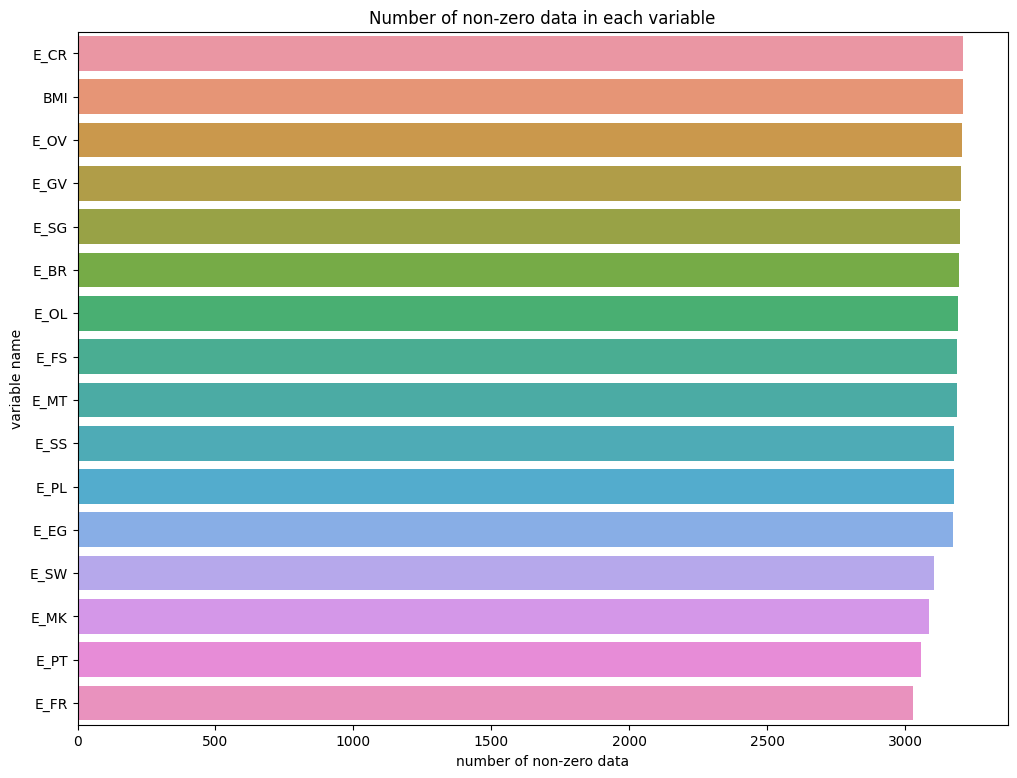

('E_GV', 'E_OV', 0.6218306210216428)
('E_OV', 'E_GV', 0.6218306210216428)


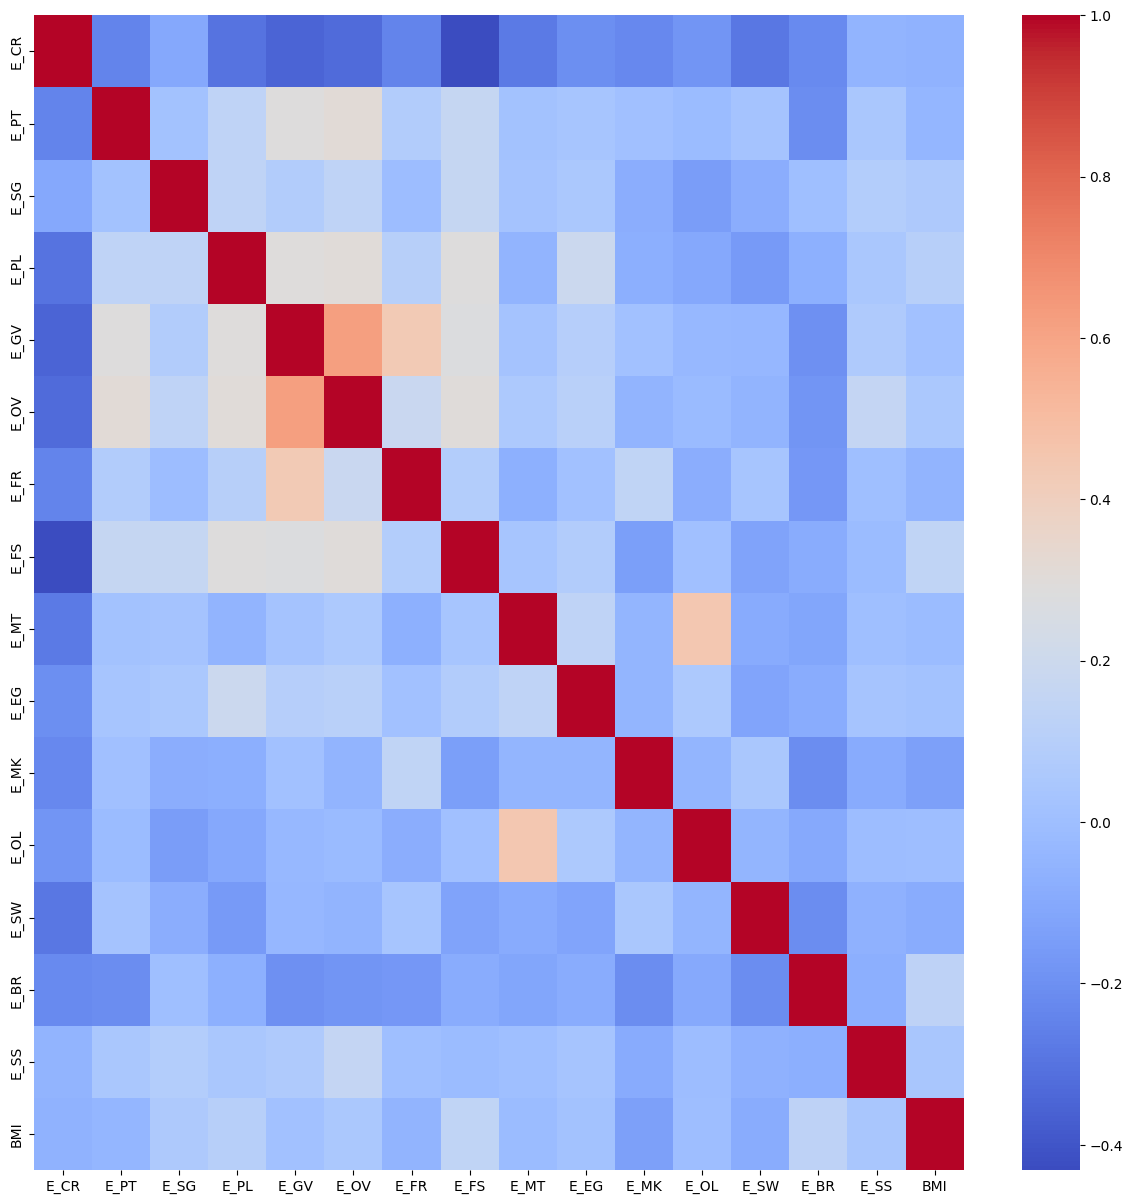

In [20]:
# 変数選択
values_dataframe = cleaned_data_copy.loc[:, 'E_CR':'E_SS'].copy()
values_dataframe['total_intake'] = cleaned_data_copy['total_intake']
# 合計摂取量で割る
values_dataframe = values_dataframe.drop(['total_intake'],axis=1).div(values_dataframe['total_intake'], axis=0)
print(values_dataframe.head(1))
# データ数と相関の確認
values_dataframe['BMI'] = cleaned_data_copy['BMI']
checksVariables(values_dataframe)

In [21]:
# 変数追加
values_dataframe['AGE'] = cleaned_data_copy['AGE']
values_dataframe['SEX'] = cleaned_data_copy['SEX']

In [22]:
# NA処理
values_dataframe_cleaned = values_dataframe.dropna()

### LiNGAMの関数定義

In [23]:
# 解析に使用する変数の選択（）
def select(df):
    # 基本統計量の確認
    df.describe()

    # 各列について、上:0.5%,下:0.5%のデータを外れ値として除去
    for column in df.columns:
        lower_limit = df[column].quantile(0.005)
        upper_limit = df[column].quantile(0.995)
        df = df[(df[column] > lower_limit) & (df[column] < upper_limit)]

    # 修正されたデータフレームを表示
    df.describe()

    len(df)

    return df

In [24]:
def modeling(selected_columns):
  # 標準化
  scaler = StandardScaler()
  Xy = scaler.fit_transform(selected_columns)

  # モデル作成
  model = lingam.DirectLiNGAM(random_state=1)
  model.fit(Xy)

  # 因果の順番
  print(f"因果の順番\n{model.causal_order_}\n\n")

  # 隣接行列
  print(f"隣接行列\n{model.adjacency_matrix_}\n\n")

  # 推定した因果モデルにおける、誤差同士の独立性のp値
  p_values = model.get_error_independence_p_values(Xy)
  print(f"推定した因果モデルにおける、誤差同士の独立性のp値\n{p_values}\n\n")

  return model

In [25]:
def gragh(model, selected_columns,dagname):
    # 因果グラフの描画
    dot = make_dot(model.adjacency_matrix_, labels=selected_columns.columns.to_list())
    dot.format = 'png'
    dot.render(dagname)
    return dot

In [26]:
def lingam_matrix(df):
    scaler = StandardScaler()
    Xy = scaler.fit_transform(df)

    model = lingam.DirectLiNGAM(random_state=1)
    result = model.bootstrap(Xy, n_sampling=100)
    # sklearn.utils.resampleで重複ありのリサンプリングをしている。リサンプル後のサンプル数は元データと同じ。

    # bootstrappingの各サンプルにおける、因果方向の有無のカウント結果を取得する
    cdc = result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.01, split_by_causal_effect_sign=True)
    print_causal_directions(cdc, 100, labels=df.columns.to_list())

    # カウント結果を確率として、隣接行列の形式で表示
    prob = result.get_probabilities(min_causal_effect=0.01)
    print(prob)

    # bootstrappingの各サンプルにおける、DAG(Directed Acyclic Graphs)のカウント結果を取得する
    dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
    print_dagc(dagc, 100, labels=df.columns.to_list())

    # Total Causal Effects
    causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)

    # Assign to pandas.DataFrame for pretty display
    causal_df = pd.DataFrame(causal_effects)
    labels = df.columns.to_list()
    # 'from' 列と 'to' 列のラベルを適用する
    causal_df['from'] = causal_df['from'].apply(lambda x: labels[x])
    causal_df['to'] = causal_df['to'].apply(lambda x: labels[x])
    return causal_df

In [27]:
def LiNGAM(df,dagname):
  selected_columns = select(df)
  model = modeling(selected_columns)
  dot = gragh(model, selected_columns,dagname)
  re_df = lingam_matrix(selected_columns)
  return dot,re_df

In [28]:
print(values_dataframe_cleaned.columns.tolist())

['E_CR', 'E_PT', 'E_SG', 'E_PL', 'E_GV', 'E_OV', 'E_FR', 'E_FS', 'E_MT', 'E_EG', 'E_MK', 'E_OL', 'E_SW', 'E_BR', 'E_SS', 'BMI', 'AGE', 'SEX']


## 性別で分ける
16変数

In [29]:
# 変数を指定するリスト
selected_variables = ['E_CR', 'E_PT', 'E_SG', 'E_PL', 'E_GV', 'E_OV', 'E_FR', 'E_FS', 'E_MT', 'E_EG', 'E_MK', 'E_OL', 'E_SW', 'E_BR', 'E_SS', 'BMI','SEX']

# 使用する変数を確認
df = values_dataframe_cleaned[selected_variables]
df

,E_CR,E_PT,E_SG,E_PL,E_GV,E_OV,E_FR,E_FS,E_MT,E_EG,E_MK,E_OL,E_SW,E_BR,E_SS,BMI,SEX
0,0.278666,0.010757,0.014245,0.049914,0.017423,0.010306,0.050179,0.067337,0.062115,0.022494,0.161922,0.048367,0.101427,0.054498,0.050349,22.340297,1.0
1,0.373219,0.039828,0.006189,0.028121,0.008643,0.021043,0.004932,0.025475,0.066909,0.033315,0.146727,0.060703,0.096427,0.041203,0.047265,29.384757,1.0
2,0.474831,0.010555,0.008873,0.005858,0.012603,0.016147,0.020070,0.031054,0.056143,0.061800,0.098252,0.057827,0.106532,0.025665,0.013792,19.568236,1.0
3,0.445178,0.016390,0.003795,0.003638,0.011011,0.014621,0.000000,0.096996,0.104935,0.038388,0.011996,0.058244,0.109069,0.049913,0.035825,25.854639,1.0
4,0.313361,0.037599,0.009220,0.016114,0.014448,0.013594,0.032373,0.168024,0.078076,0.044030,0.069240,0.057127,0.072484,0.033694,0.040616,23.214198,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,0.522715,0.011195,0.000062,0.040688,0.001040,0.000000,0.005450,0.012201,0.053710,0.064112,0.246516,0.004822,0.000000,0.006596,0.030894,15.061332,1.0
3297,0.322125,0.021771,0.004134,0.033107,0.014272,0.015262,0.043415,0.034801,0.050030,0.033461,0.158638,0.032521,0.125938,0.089377,0.021149,15.320256,2.0
3300,0.473000,0.017586,0.002341,0.005148,0.002701,0.004423,0.003084,0.019425,0.037332,0.011105,0.043070,0.030939,0.129782,0.197808,0.022255,18.668680,2.0
3301,0.474578,0.011312,0.003834,0.014581,0.008775,0.008742,0.034574,0.054730,0.056902,0.017913,0.180195,0.048743,0.046847,0.021541,0.016735,19.113632,1.0


In [30]:
# 0data削除
df_filtered = df[(df != 0).all(axis=1)]

# 結果を表示
print(df_filtered.describe())

              E_CR         E_PT         E_SG         E_PL         E_GV  \
count  2690.000000  2690.000000  2690.000000  2690.000000  2690.000000   
mean      0.369150     0.027447     0.009694     0.038976     0.017691   
std       0.114239     0.020406     0.007476     0.026986     0.010345   
min       0.054691     0.001531     0.000011     0.001362     0.000326   
25%       0.291856     0.012086     0.004327     0.018047     0.010257   
50%       0.364674     0.023052     0.007893     0.032917     0.015745   
75%       0.442367     0.036242     0.012753     0.054380     0.023067   
max       0.812472     0.170374     0.054120     0.168140     0.074750   

              E_OV         E_FR         E_FS         E_MT         E_EG  \
count  2690.000000  2690.000000  2690.000000  2690.000000  2690.000000   
mean      0.020947     0.025202     0.075304     0.073101     0.033367   
std       0.012073     0.020760     0.049108     0.035470     0.020273   
min       0.000147     0.000937     0

In [31]:
# 男女に分ける
male_df = df_filtered[df_filtered['SEX']==1].drop('SEX',axis=1)
female_df = df_filtered[df_filtered['SEX']==2].drop('SEX',axis=1)

因果の順番
[13, 14, 10, 7, 5, 6, 4, 1, 3, 12, 15, 8, 11, 2, 0, 9]


隣接行列
[[ 0.         -0.15135064 -0.0740481  -0.2403259  -0.08312758 -0.08127865
  -0.1651849  -0.39637407 -0.29340795  0.         -0.48130303 -0.19451519
  -0.51351046 -0.76738576 -0.13805288  0.        ]
 [ 0.          0.          0.          0.          0.10219268  0.20237396
   0.          0.          0.          0.          0.          0.
   0.         -0.12980513  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.16052601  0.11786748  0.          0.         -0.22842195
   0.          0.          0.08324794  0.        ]
 [ 0.          0.          0.          0.          0.09197585  0.16154015
   0.          0.20637682  0.          0.         -0.08369915  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.52473972
   0.39486567  0.          0.          0.          0.          0.
   0.          0.   

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=3.738e-04, previous alpha=7.476e-05, with an active set of 15 regressors.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 17 iterations, alpha=4.785e-03, previous alpha=2.392e-03, with an active set of 14 regressors.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=9.876e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps paramete

E_CR <--- E_BR (b<0) (100.0%)
E_MK <--- E_BR (b<0) (100.0%)
E_CR <--- E_FS (b<0) (100.0%)
E_CR <--- E_FR (b<0) (100.0%)
E_SW <--- E_BR (b<0) (100.0%)
E_CR <--- E_MT (b<0) (99.0%)
E_SG <--- E_OL (b<0) (99.0%)
E_CR <--- E_MK (b<0) (99.0%)
[[0.   0.97 0.97 0.92 0.96 0.93 1.   1.   0.99 0.8  0.99 0.99 0.96 1.
  0.95 0.04]
 [0.03 0.   0.05 0.1  0.52 0.4  0.22 0.22 0.05 0.04 0.07 0.05 0.11 0.94
  0.31 0.22]
 [0.01 0.02 0.   0.02 0.05 0.14 0.1  0.97 0.53 0.16 0.2  0.99 0.24 0.11
  0.33 0.14]
 [0.08 0.32 0.1  0.   0.44 0.61 0.16 0.9  0.22 0.5  0.48 0.47 0.39 0.21
  0.29 0.13]
 [0.01 0.27 0.03 0.17 0.   0.52 1.   0.56 0.06 0.13 0.05 0.14 0.17 0.05
  0.3  0.  ]
 [0.07 0.59 0.1  0.36 0.48 0.   0.67 0.8  0.36 0.09 0.22 0.16 0.18 0.74
  0.78 0.  ]
 [0.   0.02 0.02 0.02 0.   0.3  0.   0.56 0.17 0.   0.62 0.03 0.29 0.92
  0.03 0.16]
 [0.   0.06 0.   0.1  0.13 0.19 0.24 0.   0.06 0.16 0.72 0.01 0.06 0.07
  0.05 0.09]
 [0.01 0.07 0.18 0.23 0.09 0.17 0.44 0.13 0.   0.36 0.26 0.48 0.45 0.75
  0.07 0.04]


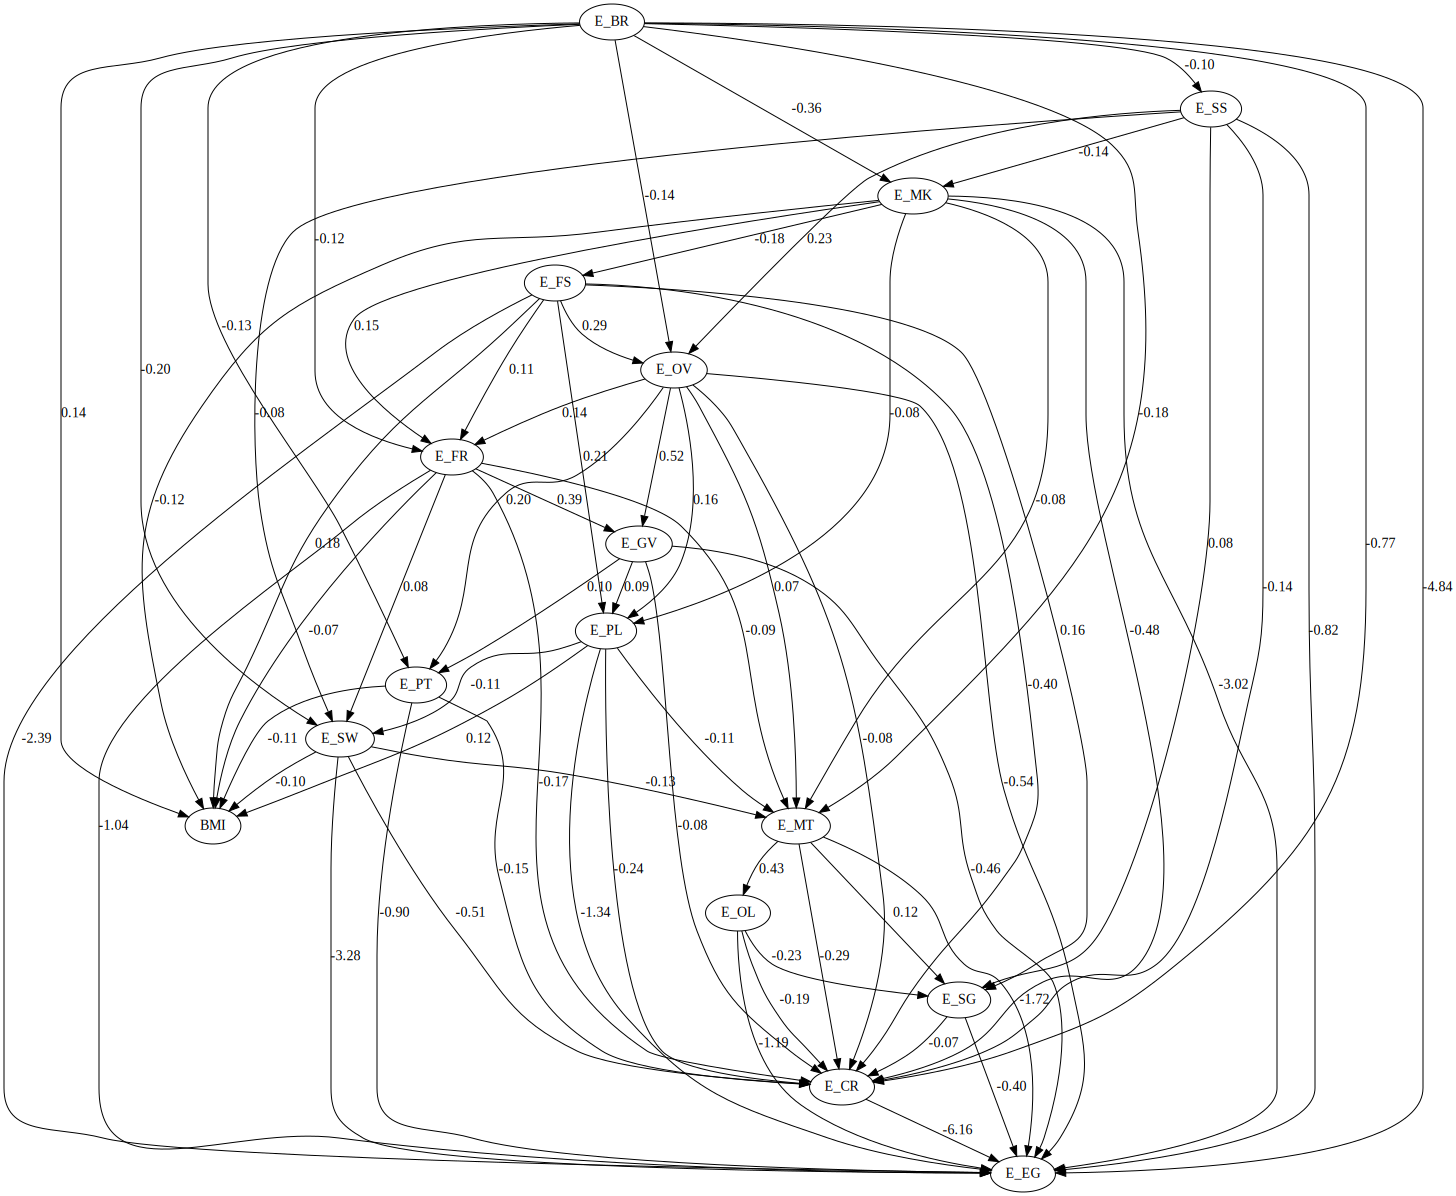

In [32]:
male_dot,male_causal_df = LiNGAM(male_df,'nutr_ratio_male_allVar')
male_dot

In [33]:
male_causal_df

,from,to,effect,probability
0,E_BR,BMI,0.246066,1.00
1,E_FR,E_GV,0.461861,1.00
2,E_BR,E_MK,-0.347423,1.00
3,E_FR,E_CR,-0.247936,1.00
4,E_FS,E_CR,-0.462554,1.00
...,...,...,...,...
217,E_CR,E_SG,-15.560941,0.01
218,E_PT,E_BR,-0.153722,0.01
219,E_PL,E_BR,0.174660,0.01
220,E_CR,E_MK,-2.043363,0.01


因果の順番
[13, 10, 14, 12, 7, 1, 9, 15, 5, 11, 8, 2, 6, 4, 3, 0]


隣接行列
[[ 0.         -0.19771504 -0.06892008 -0.25501876 -0.09530619 -0.11205701
  -0.19306199 -0.46238816 -0.32232555 -0.18729977 -0.47960669 -0.22133061
  -0.63276125 -0.39634322 -0.14310409  0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.1874099   0.          0.          0.          0.
   0.         -0.10618976  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.09379952
   0.          0.15484445  0.12096569  0.          0.         -0.30501888
   0.          0.          0.          0.        ]
 [ 0.          0.          0.05818549  0.          0.15910506  0.14103489
   0.          0.15024615 -0.07399966  0.08426362 -0.0479666  -0.09801074
  -0.13331076  0.          0.          0.0528053 ]
 [ 0.          0.13928271  0.          0.          0.          0.46888655
   0.25796147  0.08510738  0.          0.          0.          0.
   0.       

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 19 iterations, alpha=2.849e-04, previous alpha=2.630e-04, with an active set of 14 regressors.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 21 iterations, alpha=2.104e-03, previous alpha=5.479e-04, with an active set of 14 regressors.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 19 iterations, alpha=2.630e-04, previous alpha=2.548e-05, with an active set of 14 regressors.
  warnings.warn(
/usr/lo

E_CR <--- E_PT (b<0) (100.0%)
E_CR <--- E_BR (b<0) (100.0%)
E_CR <--- E_MK (b<0) (100.0%)
E_CR <--- E_FS (b<0) (100.0%)
E_CR <--- E_FR (b<0) (100.0%)
E_CR <--- E_OL (b<0) (100.0%)
E_CR <--- E_MT (b<0) (98.0%)
E_CR <--- E_SS (b<0) (98.0%)
[[0.   1.   0.88 0.92 0.96 0.81 1.   1.   0.98 0.96 1.   1.   0.96 1.
  0.98 0.03]
 [0.   0.   0.   0.02 0.05 0.01 0.03 0.58 0.   0.07 0.1  0.   0.11 0.81
  0.02 0.  ]
 [0.09 0.12 0.   0.46 0.22 0.55 0.32 1.   0.88 0.13 0.12 0.91 0.46 0.32
  0.4  0.01]
 [0.08 0.62 0.3  0.   0.36 0.4  0.35 0.89 0.29 0.76 0.52 0.55 0.82 0.13
  0.16 0.34]
 [0.04 0.94 0.1  0.62 0.   0.51 1.   0.78 0.1  0.2  0.11 0.06 0.16 0.06
  0.14 0.08]
 [0.19 0.98 0.33 0.6  0.49 0.   0.36 0.77 0.41 0.36 0.54 0.24 0.35 0.48
  0.91 0.14]
 [0.   0.02 0.24 0.04 0.   0.35 0.   0.21 0.12 0.03 0.68 0.37 0.15 0.17
  0.06 0.04]
 [0.   0.41 0.   0.11 0.07 0.18 0.22 0.   0.04 0.08 0.74 0.04 0.64 0.72
  0.3  0.26]
 [0.02 0.11 0.07 0.18 0.05 0.12 0.17 0.06 0.   0.6  0.38 0.86 0.78 0.26
  0.15 0.01]

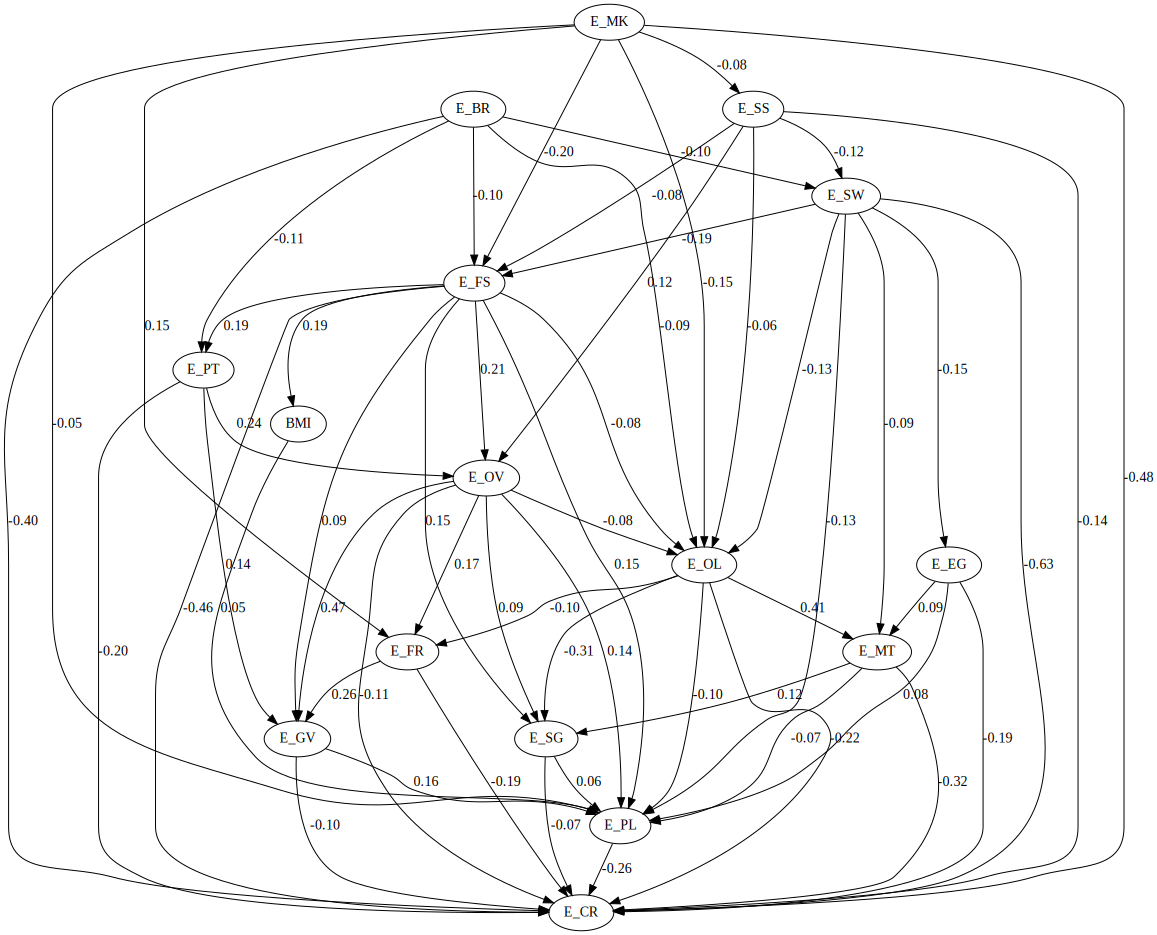

In [34]:
female_dot,female_causal_df = LiNGAM(female_df,'nutr_ratio_female_allVar')
female_dot

In [35]:
female_causal_df

,from,to,effect,probability
0,E_PT,E_CR,-0.247171,1.00
1,E_FS,E_SG,0.182008,1.00
2,E_FR,E_GV,0.318900,1.00
3,E_BR,E_CR,-0.203555,1.00
4,E_FS,E_CR,-0.502401,1.00
...,...,...,...,...
209,E_FS,E_EG,0.081029,0.01
210,E_MT,E_FS,0.087036,0.01
211,BMI,E_EG,0.092520,0.01
212,E_SS,E_PT,-0.085230,0.01


## 8変数


In [36]:
print(values_dataframe_cleaned.columns.tolist())

['E_CR', 'E_PT', 'E_SG', 'E_PL', 'E_GV', 'E_OV', 'E_FR', 'E_FS', 'E_MT', 'E_EG', 'E_MK', 'E_OL', 'E_SW', 'E_BR', 'E_SS', 'BMI', 'AGE', 'SEX']


In [38]:
# 変数を指定するリスト
selected_variables = ['E_CR', 'E_PT', 'E_SG', 'E_PL', 'E_GV', 'E_FS', 'E_MT',  'BMI','SEX']
# 使用する変数を確認
df = values_dataframe_cleaned[selected_variables]
# 0data削除
df_filtered = df[(df != 0).all(axis=1)]
# 男女に分ける
male_df = df_filtered[df_filtered['SEX']==1].drop('SEX',axis=1)
female_df = df_filtered[df_filtered['SEX']==2].drop('SEX',axis=1)

因果の順番
[5, 4, 6, 2, 1, 3, 0, 7]


隣接行列
[[ 0.         -0.0974824   0.         -0.14512156 -0.15404697 -0.31490211
  -0.20872429  0.        ]
 [ 0.          0.          0.          0.          0.24421477  0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.14433885
   0.          0.        ]
 [ 0.          0.          0.          0.          0.19506427  0.21883083
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.25256449
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.         -0.14963726  0.          0.12480526  0.          0.17690902
   0.          0.        ]]


推定した因果モデルにおける、誤差同士の独立性のp値
[[0.00000000e+00 3.13431268e-02 8.13413575e-01 7.60420862e-01
  3.55734278e-01 2.21530263e-01 2.48013915e-04 4.37102279e-01]
 [3.13431268e-02 0.00000

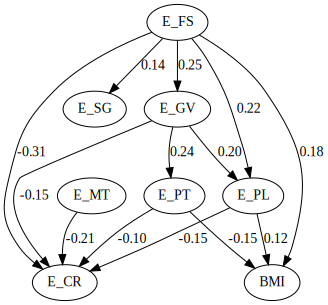

In [39]:
male_dot,male_causal_df = LiNGAM(male_df,'nutr_ratio_male_8Var')
male_dot

In [45]:
male_causal_df[male_causal_df['to']=='BMI']

,from,to,effect,probability
10,E_FS,BMI,0.202638,0.76
13,E_PT,BMI,-0.120844,0.46
14,E_PL,BMI,0.137836,0.44
17,E_SG,BMI,0.089848,0.31
31,E_CR,BMI,-0.098818,0.07
39,E_GV,BMI,-0.130385,0.02
40,E_MT,BMI,0.074277,0.02


因果の順番
[5, 1, 4, 3, 6, 2, 0, 7]


隣接行列
[[ 0.         -0.11401741  0.         -0.15024188 -0.18340848 -0.29162728
  -0.25591131  0.        ]
 [ 0.          0.          0.          0.          0.          0.18632264
   0.          0.        ]
 [ 0.          0.          0.          0.12877085  0.          0.15489188
   0.          0.        ]
 [ 0.          0.          0.          0.          0.26492241  0.21001093
   0.          0.        ]
 [ 0.          0.2426559   0.          0.          0.          0.19311988
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.06794751  0.          0.16457918
   0.          0.        ]]


推定した因果モデルにおける、誤差同士の独立性のp値
[[0.00000000e+00 2.41284377e-04 9.13118384e-01 1.16470513e-01
  6.84306150e-03 4.34914753e-06 2.11844222e-03 2.53143504e-01]
 [2.41284377e-04

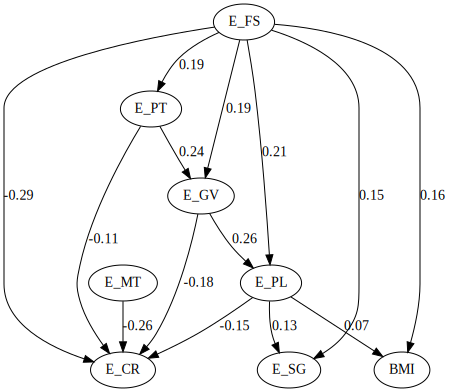

In [41]:
female_dot,female_causal_df = LiNGAM(female_df,'nutr_ratio_female_8VAr')
female_dot

In [46]:
female_causal_df[female_causal_df['to']=='BMI']

,from,to,effect,probability
7,E_FS,BMI,0.189662,0.90
14,E_PL,BMI,0.090006,0.41
18,E_GV,BMI,0.080148,0.30
25,E_PT,BMI,0.074471,0.14
27,E_SG,BMI,0.075107,0.13
33,E_CR,BMI,-0.071956,0.03
